In [1]:
import os, sys, math, random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from datasets import load_dataset

# Point PYTHONPATH to your TTML build (adjust if your path differs)
sys.path.append(f'{os.environ["HOME"]}/git/tt-metal/tt-train/build/sources/ttml')
import _ttml

# Repro
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    _ttml.autograd.AutoContext.get_instance().set_seed(seed)

set_seed(42)

# MNIST constants
NUM_CLASSES = 10
IMG_H, IMG_W = 28, 28
N_FEATURES = IMG_H * IMG_W  # 784


ImportError: std::bad_cast

In [ ]:
def load_mnist() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns:
        x_train [Ntr, 784] float32 in [0,1]
        y_train [Ntr] int32  (class indices)
        x_test  [Nte, 784] float32 in [0,1]
        y_test  [Nte] int32
    """
    ds = load_dataset("mnist")

    x_train = np.stack([np.array(img, dtype=np.float32) for img in ds["train"]["image"]], axis=0)
    y_train = np.array(ds["train"]["label"], dtype=np.uint32)
    x_test  = np.stack([np.array(img, dtype=np.float32) for img in ds["test"]["image"]], axis=0)
    y_test  = np.array(ds["test"]["label"],  dtype=np.uint32)

    # scale to [0,1] and flatten
    x_train = (x_train / 255.0).reshape(-1, N_FEATURES).astype(np.float32)
    x_test  = (x_test  / 255.0).reshape(-1, N_FEATURES).astype(np.float32)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_mnist()

# Optional quick smoke test to speed things up while iterating
# take = 10_000
# x_train, y_train = x_train[:take], y_train[:take]
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((60000, 784), (60000,), (10000, 784), (10000,))

In [ ]:
@dataclass
class TTMLConfig:
    batch_size: int = 128
    epochs: int = 5
    lr: float = 0.1
    momentum: float = 0.0
    weight_decay: float = 0.0
    dampening: float = 0.0
    nesterov: bool = False
    seed: int = 42
    log_every: int = 100  # print every N steps

def train_ttml_linear_classifier_ce(
    x_train: np.ndarray,
    y_train: np.ndarray,
    cfg: TTMLConfig,
) -> Tuple[object, List[float]]:
    """
    Trains a mlp(784 ->128 -> 128 -> 10) with cross-entropy loss.
    TTML tensor shapes used here:
      inputs  : [B, 1, 1, 784]  (float32)
      targets : [B, 1, 1, 1]    (int32 class indices)
    If your CE expects shape [B] instead, you can squeeze before creating the TTML tensor.
    """
    set_seed(cfg.seed)

    #model = _ttml.modules.create_linear_regression_model(N_FEATURES, NUM_CLASSES)
    model_params = _ttml.modules.MultiLayerPerceptronParameters.create(784, [128, 128], 10)
    model = _ttml.modules.MultiLayerPerceptron.create(model_params)
    loss_fn = _ttml.ops.cross_entropy_loss  # logits + int32 targets
    opt_cfg = _ttml.optimizers.SGDConfig.make(
        cfg.lr, cfg.momentum, cfg.weight_decay, cfg.dampening, cfg.nesterov
    )
    opt = _ttml.optimizers.SGD(model.parameters(), opt_cfg)
    model.train()

    num_samples = x_train.shape[0]
    indices = np.arange(num_samples)
    losses: List[float] = []
    step = 0

    for epoch in range(cfg.epochs):
        np.random.shuffle(indices)
        pos = 0
        while pos < num_samples:
            end_pos = min(num_samples, pos + cfg.batch_size)
            batch_idx = indices[pos:end_pos]
            bsz = end_pos - pos

            xb = x_train[batch_idx].reshape(bsz, 1, 1, N_FEATURES).astype(np.float32)
            # Cross-entropy targets must be INT32 class indices:
            yb_idx = y_train[batch_idx].reshape(bsz, 1).astype(np.uint32)

            tt_x = _ttml.autograd.Tensor.from_numpy(xb)
            tt_y_idx = _ttml.autograd.Tensor.from_numpy(yb_idx, row_major=True)  # INT32 tensor

            opt.zero_grad()
            logits = model(tt_x)  # [B,1,1,10] raw logits
            loss = loss_fn(logits, tt_y_idx, _ttml.ops.ReduceType.MEAN)
            loss.backward(False)
            opt.step()

            step += 1
            loss_val = float(loss.to_numpy())
            losses.append(loss_val)
            if cfg.log_every and (step % cfg.log_every == 0):
                print(f"[epoch {epoch+1}/{cfg.epochs}] step={step:5d} loss={loss_val:.6f}")

            pos = end_pos

    model.eval()
    return model, losses

cfg = TTMLConfig(epochs=5, batch_size=128, lr=0.1, log_every=100)
print(_ttml.modules)
model, losses = train_ttml_linear_classifier_ce(x_train, y_train, cfg)
len(losses), losses[:3]


AttributeError: module '_ttml.modules' has no attribute 'MultiLayerPerceptronParameters'

In [ ]:
def predict_logits_ttml(model, x: np.ndarray, batch_size: int = 2048) -> np.ndarray:
    out = []
    n = x.shape[0]
    pos = 0
    while pos < n:
        end_pos = min(n, pos + batch_size)
        bsz = end_pos - pos
        xb = x[pos:end_pos].reshape(bsz, 1, 1, N_FEATURES).astype(np.float32)
        tt_x = _ttml.autograd.Tensor.from_numpy(xb)
        logits = model(tt_x).to_numpy().reshape(bsz, NUM_CLASSES)
        out.append(logits)
        pos = end_pos
    return np.concatenate(out, axis=0)

def softmax(z: np.ndarray, axis: int = -1) -> np.ndarray:
    zmax = np.max(z, axis=axis, keepdims=True)
    ez = np.exp(z - zmax)
    return ez / np.sum(ez, axis=axis, keepdims=True)

def accuracy(pred: np.ndarray, true: np.ndarray) -> float:
    return float(np.mean(pred == true))




Test accuracy: 91.28%


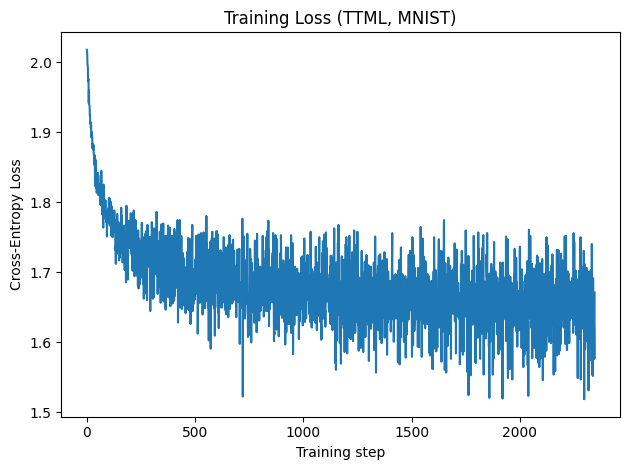

In [ ]:
# --- Evaluate ---
logits = predict_logits_ttml(model, x_test)
probs = softmax(logits, axis=1)
y_pred = np.argmax(probs, axis=1).astype(np.int32)
acc = accuracy(y_pred, y_test)
print(f"Test accuracy: {acc*100:.2f}%")

# --- Loss plot ---
plt.figure()
plt.plot(np.arange(1, len(losses)+1), losses)
plt.xlabel("Training step")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss (TTML, MNIST)")
plt.tight_layout()
plt.show()

# --- Prediction grid ---


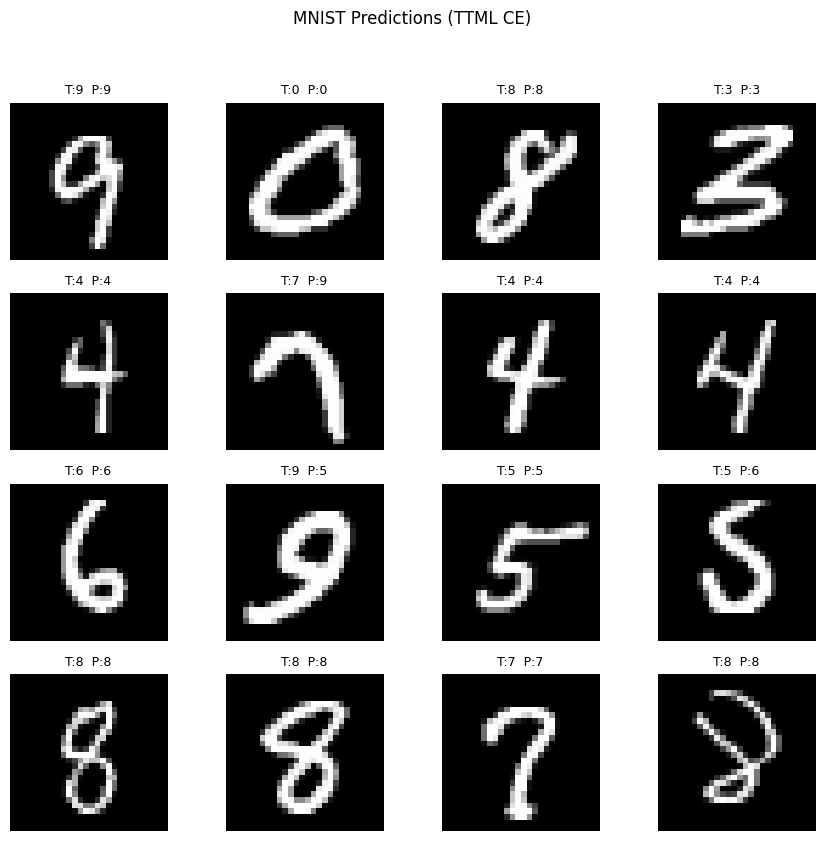

In [ ]:
def show_predictions_grid(
    images_flat: np.ndarray,
    true_labels: np.ndarray,
    pred_labels: np.ndarray,
    n: int = 16,
):
    n = min(n, images_flat.shape[0])
    idx = np.random.choice(images_flat.shape[0], n, replace=False)
    imgs = images_flat[idx].reshape(n, IMG_H, IMG_W)
    trues = true_labels[idx]
    preds = pred_labels[idx]

    side = int(math.ceil(math.sqrt(n)))
    plt.figure(figsize=(side*2.2, side*2.2))
    for i in range(n):
        ax = plt.subplot(side, side, i + 1)
        ax.imshow(imgs[i], cmap="gray")
        ax.set_title(f"T:{trues[i]}  P:{preds[i]}", fontsize=9)
        ax.axis("off")
    plt.suptitle("MNIST Predictions (TTML CE)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

show_predictions_grid(x_test, y_test, y_pred, n=16)